In [1]:
import cv2,os,torch
import json
import matplotlib.pyplot as plt
import numpy as np
from load_data import load_data
from torch.utils.data import Dataset,DataLoader
import albumentations as albu
import torchvision
import torch.nn as nn
import sys
sys.path.append('/home/chenyixin/chenyixin/')
import segmentor

Backbone HRNet Pretrained weights at: ./checkpoints/hrnetv2_32_model_best_epoch96.pth, only usable for HRNetv2-32


In [6]:
def load_data(path='./data',mode='train',verbose=False):
    types_dict = {'/恶性/':'malign', '/良性/':'benign', '/交界性/':'borderline'}
    imgs,masks,type_labels,pathology_labels = [],[],[],[]
    name = []
    
    for basepath,dirnames,files in os.walk(path):
        jpg = [f for f in files if '.jpg' in f]
        if len(jpg) == 0:
            continue
        for j in jpg:
            jpg_path = os.path.join(basepath,j)
            img = cv2.imread(jpg_path)

            try:
                js = json.load(open(jpg_path.replace('.jpg','.json'),'r'))
            except:
                print(jpg_path)
                break
            if len(img.shape)==2:    
                mask = np.zeros_like(img)
            elif len(img.shape) ==3:
                mask = np.zeros_like(img[:,:,0])
            for shape in js['shapes']:
                cv2.fillPoly(mask,[np.int32(shape['points'])],color=255)
                
            for t in types_dict:
                if t in basepath:
                    break
            na = basepath.replace("/Image","").split("/")[-1]
            
            if types_dict[t] == "borderline":
                continue
            imgs.append(img)
            masks.append(mask)
            type_labels.append(types_dict[t])
            pathology_labels.append(0)
            name.append(na)
                
    return imgs,masks,type_labels,pathology_labels,name

In [7]:
!ls ./AI基线资料乳头/

彩色			   巧囊已核实图及表.xlsx      原发卵巢癌.xlsx
灰色			   生殖已核实图及表.xlsx      转移已核实图及表.xlsx
交界性已核实图及表.xlsx    性索间质已核实图及表.xlsx
其它上皮已核实图及表.xlsx  炎症已核实图及表.xlsx


In [8]:
g_imgs,g_masks,g_type_labels,g_pathology_labels,g_name = load_data(path='./AI基线资料乳头/灰色/',verbose=False)
c_imgs,c_masks,c_type_labels,c_pathology_labels,c_name = load_data(path='./AI基线资料乳头/彩色/',verbose=False)

./AI基线资料乳头/灰色/良性/生殖/杨囡_02.201709121224.01成熟性畸胎瘤/Images/02.201709121224.01.0013.1505201809.jpg
./AI基线资料乳头/灰色/良性/巧囊/柴春蕾_02.201612190406.01巧囊/Images/02.201612190406.01.0004.1482111408.jpg
./AI基线资料乳头/彩色/恶性/原发卵巢癌/蒋秀丽_02.202112110297.01高级别浆液性癌/Images/02.202112110297.01.20188.0007.10583900218.jpg
./AI基线资料乳头/彩色/恶性/转移癌/温镝飞_02.201906110907.01平滑肌瘤卵巢种植转移瘤C/Images/02.201906110907.01.0005.11215400612.jpg
./AI基线资料乳头/彩色/恶性/转移癌/胡春华_02.201506090239.01结肠腺癌卵巢转移/郭丽娜_02.201506020684.01浆液性囊腺瘤/Images/02.201506020684.01.0009.1433215609.jpg
./AI基线资料乳头/彩色/良性/性索间质/胡桂桃_02.201804090182.01梭形细胞瘤即卵泡膜细胞瘤C/Images/02.201804090182.01.0012.1523234956.jpg
./AI基线资料乳头/彩色/良性/性索间质/彭文红_02.201908221713.02卵泡膜纤维瘤伴水肿C/Images/02.201908221713.02.21288.0006.14394100671.jpg
./AI基线资料乳头/彩色/良性/性索间质/白丽_02.201904110646.01纤维卵泡膜细胞瘤C/Images/02.201904110646.01.0005.09061200428.jpg
./AI基线资料乳头/彩色/良性/其它上皮/吕艳文_02.201907300832.01黏液性囊腺瘤C/Images/02.201907300832.01.21288.0010.09130600910.jpg
./AI基线资料乳头/彩色/良性/其它上皮/崔爱成_02.201911140653.01黏液囊腺瘤伴灶状钙化C/Images

In [9]:
## combine
case = {}
def extract_name(n):
    n = n.split('_')
    n1,n2 = n[0],n[1]
    n1 += '_'
    for n22 in n2:
        if not (n22.isdigit() or n22 in ['.','C'] ):
            n1 += n22
    return n1
for i,n in enumerate(g_name):
    n1 = extract_name(n)
    if not case.__contains__(n1):
        case[n1] = {'gray':[(g_imgs[i],g_masks[i],g_type_labels[i],g_pathology_labels[i])],
                    'color':[]}
    else:
        case[n1]['gray'].append((g_imgs[i],g_masks[i],g_type_labels[i],g_pathology_labels[i]))
for i,n in enumerate(c_name):
    n1 = extract_name(n)
    if not case.__contains__(n1):
        case[n1] = {'gray':[],
                    'color':[(c_imgs[i],c_masks[i],c_type_labels[i],c_pathology_labels[i])]}
    else:
        case[n1]['color'].append((c_imgs[i],c_masks[i],c_type_labels[i],c_pathology_labels[i]))

In [10]:
test = ['2021','2020','2019']
test_name = [] 
for i in range(len(g_name)):
    istest = False
    for t in test:
        if f'.{t}' in g_name[i]:
            n1 = extract_name(g_name[i])
            test_name.append(n1)
for i in range(len(c_name)):
    istest = False
    for t in test:
        if f'.{t}' in g_name[i]:
            n1 = extract_name(g_name[i])
            test_name.append(n1)
test_name = list(set(test_name))

# malign & benign & borderline


In [11]:
def save_img(img,name):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = np.uint8(img * 255)
    cv2.imwrite(f'./forpaper/3/{name}.png',img)
class mydataset(Dataset):
    def __init__(self,case,croptumour=False,mode='train'):
        self.case = case
        self.keys = list(case.keys())
        self.keys = sorted(self.keys)
        self.type_dict = {'benign':0,'malign':1}
        
        self.trans = albu.Compose([
            albu.OneOf([
                albu.Resize(height=300,width=400),
            ],p=1),
            albu.ShiftScaleRotate(p=0.5),
            albu.JpegCompression(p=0.2),
            albu.GaussianBlur(p=0.2),
            albu.RandomBrightnessContrast(p=0.5),
            albu.HorizontalFlip(p=0.2),
            albu.VerticalFlip(p=0.2),
        ])
        self.valtrans = albu.Compose([
            albu.Resize(height=300,width=400),
        ])
        self.croptumour = croptumour
        self.mode = mode
        
    def __getitem__(self,index):
        gray = self.case[self.keys[index]]['gray']
        color = self.case[self.keys[index]]['color']
        
        gray_imgs,gray_masks = [],[]
        tlabel = -1
        for ii,(img,mask,tlabel,plabel)in enumerate(gray):
            tlabel = self.type_dict[tlabel]
            if np.random.rand() < 0.2 and self.mode=='train':
                continue
            mask[mask!=0] = 1
            save_img(img,f'gray_f_{ii}.png')
            if self.croptumour:
                img = self.cutedge(img,mask)
                save_img(img,f'gray_crop_{ii}.png')
            if self.mode == 'train':
                trans = self.trans(image=img,mask=mask)
                img,mask = trans['image'],trans['mask']
            else:
                trans = self.valtrans(image=img,mask=mask)
                img,mask = trans['image'],trans['mask']
            if len(img.shape)==2:
                img = torch.tensor(img/255).float().unsqueeze(0)
            elif len(img.shape)==3:
                img = torch.tensor(img/255).float().permute(2,0,1)
            mask = torch.tensor(mask).float()
            gray_imgs.append(img.unsqueeze(0))
            gray_masks.append(mask.unsqueeze(0))
        if len(gray_imgs) == 0:
            gray_imgs = None;
            gray_masks = None
        else:
            gray_imgs = torch.cat(gray_imgs,dim=0)
            gray_masks = torch.cat(gray_masks,dim=0)
            
        
        color_imgs,color_masks = [],[]
        for ii,(img,mask,tlabel,plabel) in enumerate(color):
            tlabel = self.type_dict[tlabel]
            if np.random.rand() < 0.2 and self.mode=='train':
                continue
            mask[mask!=0] = 1
            save_img(img,f'color_f_{ii}.png')
            if self.croptumour:
                img = self.cutedge(img,mask)
                save_img(img,f'color_crop_{ii}.png')
            if self.mode == 'train':
                trans = self.trans(image=img,mask=mask)
                img,mask = trans['image'],trans['mask']
            else:
                trans = self.valtrans(image=img,mask=mask)
                img,mask = trans['image'],trans['mask']
            if len(img.shape)==2:
                img = torch.tensor(img/255).float().unsqueeze(0)
            elif len(img.shape)==3:
                img = torch.tensor(img/255).float().permute(2,0,1)
            mask = torch.tensor(mask).float()
            color_imgs.append(img.unsqueeze(0))
            color_masks.append(mask.unsqueeze(0))
        if len(color_imgs) == 0:
            color_imgs,color_masks = None,None
        else:
            color_imgs = torch.cat(color_imgs,dim=0)
            color_masks = torch.cat(color_masks,dim=0)
        tlabel = torch.tensor(tlabel).long()
        
        return (gray_imgs,gray_masks),(color_imgs,color_masks),tlabel,self.keys[index]
    def __len__(self):
        return len(self.keys)
    
    def cutedge(self,img,mask):
        tmp1 = np.max(mask,axis=0)
        tmp2 = np.max(mask,axis=1)
        for a,t in enumerate(tmp1):
            if t != 0:
                break
        for b,t in enumerate(tmp1[::-1]):
            if t != 0:
                break
        for c,t in enumerate(tmp2):
            if t != 0:
                break
        for d,t in enumerate(tmp2[::-1]):
            if t != 0:
                break
        img = img[c:len(tmp2)-d,a:len(tmp1)-b]
        return img

In [13]:
class Identity(nn.Module):
    def __init(self):
        super(Identity,self).__init__()
    def forward(self,x):
        return x
class Model(nn.Module):
    def __init__(self,gray_in,color_in):
        super(Model,self).__init__()
        g=16
        self.gray_feat = torchvision.models.resnet18(pretrained=True)
        self.color_feat = torchvision.models.resnet18(pretrained=True)
        self.gray_feat = nn.Sequential(
            nn.Conv2d(gray_in,64,7,2,0,bias=False),
            nn.GroupNorm(num_groups=g,num_channels=64),
            nn.LeakyReLU(),
            nn.Conv2d(64,128,3,2,0),
            nn.GroupNorm(num_groups=g,num_channels=128),
            nn.LeakyReLU(),
            nn.Conv2d(128,128,3,1,0),
            nn.GroupNorm(num_groups=g,num_channels=128),
            nn.LeakyReLU(),
            nn.Conv2d(128,256,3,2,0),
            nn.GroupNorm(num_groups=g,num_channels=256),
            nn.LeakyReLU(),
            nn.Conv2d(256,256,3,1,0),
            nn.GroupNorm(num_groups=g,num_channels=256),
            nn.LeakyReLU(),
            nn.Conv2d(256,512,3,2,0),
            nn.GroupNorm(num_groups=g,num_channels=512),
            nn.LeakyReLU(),
            nn.Conv2d(512,512,3,1,0),
            nn.GroupNorm(num_groups=g,num_channels=512),
            nn.LeakyReLU(),
        )
        self.color_feat = nn.Sequential(
            nn.Conv2d(gray_in,64,7,2,0,bias=False),
            nn.GroupNorm(num_groups=g,num_channels=64),
            nn.LeakyReLU(),
            nn.Conv2d(64,128,3,2,0),
            nn.GroupNorm(num_groups=g,num_channels=128),
            nn.LeakyReLU(),
            nn.Conv2d(128,128,3,1,0),
            nn.GroupNorm(num_groups=g,num_channels=128),
            nn.LeakyReLU(),
            nn.Conv2d(128,256,3,2,0),
            nn.GroupNorm(num_groups=g,num_channels=256),
            nn.LeakyReLU(),
            nn.Conv2d(256,256,3,1,0),
            nn.GroupNorm(num_groups=g,num_channels=256),
            nn.LeakyReLU(),
            nn.Conv2d(256,512,3,2,0),
            nn.GroupNorm(num_groups=g,num_channels=512),
            nn.LeakyReLU(),
            nn.Conv2d(512,512,3,1,0),
            nn.GroupNorm(num_groups=g,num_channels=512),
            nn.LeakyReLU(),
        )
        self.feat = nn.Sequential(
            nn.Conv2d(512,1024,3,2,0,bias=True),
            nn.GroupNorm(num_groups=g,num_channels=1024),
            nn.LeakyReLU(),
            nn.Conv2d(1024,1024,3,1,0),
            nn.GroupNorm(num_groups=g,num_channels=1024),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1,1))
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024,2,bias=False),
        )
    def forward(self,gray,color):
        if gray is None and color is None:
            return None
        
        if gray is not None:
            gray = self.gray_feat(gray)
            gray = torch.mean(gray,dim=0,keepdim=True)
        if color is not None:
            color = self.color_feat(color)
            color = torch.mean(color,dim=0,keepdim=True)
        
        if gray is None:
            feat = color
        elif color is None:
            feat = gray
        else:
            feat = gray*0.5 +color*0.5
        feat = self.feat(feat)[:,:,0,0]
#         if gray is None:
#             gray = 0
#         else:
#             gray = torch.mean(gray,dim=0,keepdim=True)
#         if color is None:
#             color = 0
#         else:
#             color = torch.mean(color,dim=0,keepdim=True)
        outp = self.classifier(feat)
        return outp

In [14]:
train_case,test_case = {},{}
for key in case:
    if key in test_name:
        test_case[key] = case[key]
    else:
        train_case[key] = case[key]
# upsample small size category
a,b,c = 0,0,0
for key in test_case.keys():
    try:
        label = test_case[key]['gray'][0][2]
    except:
        label = test_case[key]['color'][0][2]
        
    if label == 'benign':
        a += 1
    elif label == 'malign':
        b += 1
    else:
        c += 1
print(a,b,c)
keys = list(train_case.keys())
for key in keys:
    try:
        label = train_case[key]['gray'][0][2]
    except:
        label = train_case[key]['color'][0][2]
    
    if label == 'benign':
        pass
    elif label == 'malign':
        train_case[key+'1'] = train_case[key]
    else:
        train_case[key+'1'] = train_case[key]
        train_case[key+'2'] = train_case[key]
        train_case[key+'3'] = train_case[key]
        train_case[key+'4'] = train_case[key]
        train_case[key+'5'] = train_case[key]
        train_case[key+'6'] = train_case[key]
        train_case[key+'7'] = train_case[key]
# a,b,c = 0,0,0
for key in train_case.keys():
    try:
        label = train_case[key]['gray'][0][2]
    except:
        label = train_case[key]['color'][0][2]
        
    if label == 'benign':
        a += 1
    elif label == 'malign':
        b += 1
    else:
        c += 1
print(a,b,c)


129 48 0
502 402 0


In [15]:
def statistic_fig_num(train_case):
    be_gray,be_color = 0,0
    bo_gray,bo_color = 0,0
    ma_gray,ma_color = 0,0
    a  = 0
    for key in train_case.keys():
        try:
            label = train_case[key]['gray'][0][2]
        except:
            label = train_case[key]['color'][0][2]

        if label == 'benign':
            be_gray += len(train_case[key]['gray'])
            be_color += len(train_case[key]['color'])
        elif label == 'malign':
            ma_gray += len(train_case[key]['gray'])
            ma_color += len(train_case[key]['color'])
        else:
            a += 1
            bo_gray += len(train_case[key]['gray'])
            bo_color += len(train_case[key]['color'])
    print(be_gray,be_color,
    bo_gray,bo_color,
    ma_gray,ma_color)
    print(a)
statistic_fig_num(train_case)
statistic_fig_num(test_case)

781 400 0 0 456 840
0
258 110 0 0 96 112
0


In [16]:
a,b,c = 0,0,0
for key in test_case.keys():
    try:
        label = test_case[key]['gray'][0][2]
    except:
        label = test_case[key]['color'][0][2]
        
    if label == 'benign':
        a += 1
    elif label == 'malign':
        b += 1
    else:
        print(label)
        c += 1
print(a,b,c)

129 48 0


In [38]:
device='cuda:0'
tr_dataset = mydataset(case,croptumour=True,mode='train')
te_dataset = mydataset(test_case,croptumour=True,mode='test')

model = Model(3,3)
model = torch.load('./weights/malign&benign_graycolor_2cls_192021.pth',map_location=device)
model = model.to(device)

cri = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=3e-6,weight_decay=3e-5)

In [40]:
def train():
    epoch_loss = 0
    preds,ys,names=[],[],[]
    
    model.train()
    update_time = 0
    total_loss = 0
    for i,(gray,color,t,name) in enumerate(tr_dataset):
        if gray[0] is None and color[0] is None:
            continue
        if gray[0] is not None:
#             gray = torch.cat([gray[0],gray[1].unsqueeze(1)*gray[0]],dim=1) 
            gray = gray[0]
            gray = gray.to(device)
        else:
            gray = None
        if color[0] is not None:
#             color = torch.cat([color[0],color[1].unsqueeze(1)*color[0]],dim=1) 
            color = color[0]
            color = color.to(device)
        else:
            color = None
        t = t.to(device).unsqueeze(0)
#         plt.imshow(gray[0].detach().cpu().numpy().transpose(1,2,0))
#         plt.show()
        pred = model(gray,color)
        loss = cri(pred,t)
        update_time += 1
        opt.zero_grad();loss.backward();opt.step()
            
            
        epoch_loss += loss.item() / len(tr_dataset)
        ys.append(t.detach().cpu().numpy())
        preds.append(torch.argmax(pred,dim=1).detach().cpu().numpy())
        print('\r{}/{},train_loss:{:.2f}'.format(i,len(tr_dataset),loss.item()),end='',flush=True)
     ## figure wise
    ys = np.concatenate(ys)
    preds = np.concatenate(preds)
    
    
    correct = len(ys[ys==preds])
    acc = correct / len(ys)
    
    print('train case wise accuracy:{:.4f}'.format(acc))
    return epoch_loss
def test(plot=False):
    epoch_loss = 0
    
    preds,ys,names=[],[],[]
    model.eval()
    for i,(gray,color,t,name) in enumerate(te_dataset):
        if gray[0] is None and color[0] is None:
            continue
        if gray[0] is not None:
#             gray = torch.cat([gray[0],gray[1].unsqueeze(1)*gray[0]],dim=1) 
            gray = gray[0]
            gray = gray.to(device)
        else:
            gray = None
        if color[0] is not None:
#             color = torch.cat([color[0],color[1].unsqueeze(1)*color[0]],dim=1) 
            color = color[0]
            color = color.to(device)
        else:
            color = None
        t = t.to(device).unsqueeze(0)
        with torch.no_grad():
            pred = model(gray,color)
            loss = cri(pred,t)
            epoch_loss += loss.item() / len(te_dataset)
            if plot :
                b = 0
                if t[b]!= torch.argmax(pred,dim=1)[b]:
                    print(name)
                    plt.figure(figsize=(10,5))
                    plt.subplot(1,2,1)
                    if gray is not None:
                        plt.imshow(gray[b].detach().cpu().numpy().transpose(1,2,0))
                    plt.subplot(1,2,2)
                    if color is not None:
                        plt.imshow(color[b].detach().cpu().numpy().transpose(1,2,0),cmap='gray')
                    plt.show()

                    print(t[b],torch.argmax(pred,dim=1)[b],name)
            
            ys.append(t.detach().cpu())
            preds.append(pred.detach().cpu())
        #print('\r{}/{},test_loss:{:.2f}'.format(i,len(te_dataset),loss.item()),end='',flush=True)
      
    ys = torch.cat(ys).numpy()
    preds = torch.cat(preds)
    preds = torch.softmax(preds,dim=1)
    argpreds = torch.argmax(preds,dim=1).numpy()
    
    correct = len(ys[ys==argpreds])
    acc = correct / len(ys)
    print('-----------------')
    print(correct,len(ys))  
    
    print('case wise accuracy:{:.4f}'.format(acc))
    return epoch_loss,{'acc':acc,'y':ys,'pred':preds.numpy()}


In [37]:
test_loss,metric = test(plot=False)


tensor([[0.0579, 0.0521]], device='cuda:0')
tensor([[ 0.9385, -0.7465]], device='cuda:0')
R冯爱华_低级别浆液癌s
tensor([[ 0.6016, -0.7432]], device='cuda:0')
tensor([[-0.3209,  0.3932]], device='cuda:0')
tensor([[-0.8197,  0.8668]], device='cuda:0')
R刘红玉_输卵管炎s
tensor([[ 2.3110, -2.1489]], device='cuda:0')
tensor([[ 1.0375, -1.1424]], device='cuda:0')
R梁素梅_透明细胞癌s
tensor([[ 1.2797, -1.5122]], device='cuda:0')
tensor([[ 1.6916, -1.4156]], device='cuda:0')
R程希敏_浆液性癌s
tensor([[ 0.9411, -0.9397]], device='cuda:0')
tensor([[ 0.3586, -0.2654]], device='cuda:0')
tensor([[ 2.2500, -2.1292]], device='cuda:0')
tensor([[-0.8482,  0.7504]], device='cuda:0')
tensor([[ 0.7286, -0.7206]], device='cuda:0')
tensor([[-0.7299,  0.6538]], device='cuda:0')
tensor([[ 1.0377, -0.7531]], device='cuda:0')
云惠珍_浆液性腺癌s
tensor([[-1.2277,  1.1425]], device='cuda:0')
任国玲_子宫内膜样腺纤维瘤s
tensor([[ 1.2285, -1.4093]], device='cuda:0')
tensor([[ 2.9015, -2.7279]], device='cuda:0')
tensor([[ 1.8091, -1.6628]], device='cuda:0')
tensor([[

tensor([[ 0.7940, -0.7578]], device='cuda:0')
tensor([[ 1.6803, -1.7530]], device='cuda:0')
tensor([[ 1.2998, -1.1996]], device='cuda:0')
-----------------
153 177
case wise accuracy:0.8644


In [ ]:
test_loss,metric = test(plot=False)
best_acc = metric['acc']
for e in range(100):
    train_loss = train()
    test_loss,metric = test(plot=False)
    print('-----------------')
    print('train_loss:{:.4f},test_loss:{:.4f}'.format(train_loss,test_loss))
    print('accuracy:{:.4f}'.format(metric['acc']))
    if best_acc < metric['acc']:  
        best_acc = metric['acc']
        torch.save(model,'./weights/malign&benign_graycolor_2cls_192021_trick.pth')
        print('==> saved model')

-----------------
153 177
case wise accuracy:0.8644
726/727,train_loss:0.08train case wise accuracy:0.8236
-----------------
151 177
case wise accuracy:0.8531
-----------------
train_loss:0.3749,test_loss:0.3678
accuracy:0.8531
726/727,train_loss:0.22train case wise accuracy:0.8281
-----------------
151 177
case wise accuracy:0.8531
-----------------
train_loss:0.3827,test_loss:0.3600
accuracy:0.8531
726/727,train_loss:0.31train case wise accuracy:0.8371
-----------------
149 177
case wise accuracy:0.8418
-----------------
train_loss:0.3778,test_loss:0.3598
accuracy:0.8418
726/727,train_loss:0.22train case wise accuracy:0.8250
-----------------
150 177
case wise accuracy:0.8475
-----------------
train_loss:0.3661,test_loss:0.3563
accuracy:0.8475
726/727,train_loss:0.80train case wise accuracy:0.8221
-----------------
150 177
case wise accuracy:0.8475
-----------------
train_loss:0.3763,test_loss:0.3517
accuracy:0.8475
726/727,train_loss:0.10train case wise accuracy:0.8270
-------------

In [19]:
y,p = metric['y'],metric['pred']
argp = np.argmax(p,axis=1)
print(y.shape,argp.shape)
acc = metrics.accuracy_score(y,argp)
print(acc)
matrix = metrics.confusion_matrix(y, argp)
print(matrix)
for i in [0,1,2]:
    fpr1, tpr1, thresholds1 = metrics.roc_curve(y,p[:,i], pos_label=i)
    roc_auc1 = metrics.auc(fpr1, tpr1)  
    print(roc_auc1)
for i in [0,1,2]:
    tmpy = y.copy()
    tmpy[tmpy == i] = -1
    tmpy[tmpy != -1] = 0
    tmpy[tmpy == -1] = 1
    fpr1, tpr1, thresholds1 = metrics.roc_curve(tmpy,p[:,i])
    roc_auc1 = metrics.auc(fpr1, tpr1)  
    print(roc_auc1)


(190,) (190,)


NameError: name 'metrics' is not defined

[[120   0   9]
 [  8   0   5]
 [  5   0  43]]
-------for cate 0--------
120 13 9
sensitivity:0.9302,specifity:0.9023,auc:0.9225
-------for cate 1--------
0 0 13
sensitivity:0.0000,specifity:nan,auc:0.7962
-------for cate 2--------
43 14 5
sensitivity:0.8958,specifity:0.7544,auc:0.9384


/tmp/ipykernel_189049/2061196594.py:21: RuntimeWarning: invalid value encountered in long_scalars
  specifity = TP/(TP+FP)


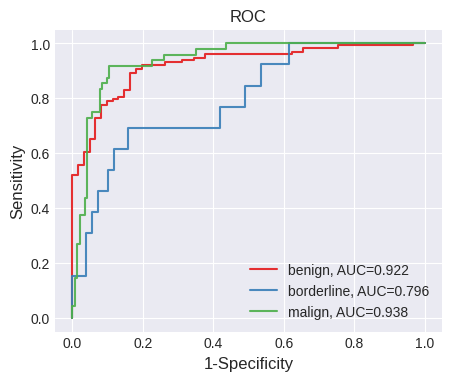

In [69]:
from sklearn import metrics
import matplotlib.pyplot as plt
def statistic(y,p,name=[]):
    palette = plt.get_cmap('Set1')
    plt.figure(figsize=(5, 4), dpi=100)
    plt.style.use('seaborn-darkgrid')
    
    argp = np.argmax(p,axis=1)
    uni = np.unique(y)
    acc = metrics.accuracy_score(y,np.argmax(p,axis=1))
    matrix = metrics.confusion_matrix(y, argp)
    print(matrix)
    for i in range(matrix.shape[0]):
        print(f'-------for cate {i}--------')
        TP,FP,TN,FN = 0,0,0,0
        TP = matrix[i,i]
        FN = np.sum(matrix[i,i+1:]) + np.sum(matrix[i,:i])
        FP = np.sum(matrix[i+1:,i]) + np.sum(matrix[:i,i])
        print(TP,FP,FN)
        sensitivity = TP / (TP+FN)
        specifity = TP/(TP+FP)
        fpr1, tpr1, thresholds1 = metrics.roc_curve(y,p[:,i], pos_label=i)
#         best = 1
#         for fprr,tprr in zip(fpr1,tpr1):
#             if (1-tprr)**2 + (fprr)**2 < best:
#                 best = (1-tprr)**2 + (fprr)**2
#                 print(tprr,1-fprr)
#                 sensitivity = tprr
#                 specifity = 1-fprr
        roc_auc1 = metrics.auc(fpr1, tpr1)  
        plt.plot(fpr1, tpr1, color=palette(i), linewidth=1.5, alpha=0.9, 
                    label=name[i]+", AUC=%0.3f" % (roc_auc1))      
        print('sensitivity:{:.4f},specifity:{:.4f},auc:{:.4f}'.format(
            sensitivity,specifity,roc_auc1))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("1-Specificity",fontsize=12)
    plt.ylabel("Sensitivity",fontsize=12)
    plt.title("ROC",fontsize=12)
    plt.legend(loc="lower right")
statistic(metric['y'],metric['pred'],name=['benign','borderline','malign'])

# METRIC

In [17]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):

    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=2)

    # 在混淆矩阵中每格的概率值
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.0f" % (c,), color='red', fontsize=15, va='center', ha='center')
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')
    
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(False, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    
    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()

In [19]:
metric['y']

array([0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2,
       2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0,
       2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0])

In [20]:
np.argmax(metric['pred'],axis=1)

array([0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0])

In [23]:
def BS(y,pred):
    N = len(y)
    y = torch.nn.functional.one_hot(torch.tensor(y)).numpy()
    bs = np.sum((y-pred)**2) / N
    return bs
    
BS(metric['y'],metric['pred'])

0.11096850246070464

/tmp/ipykernel_852796/3704790586.py:34: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(False, which='minor', linestyle='-')


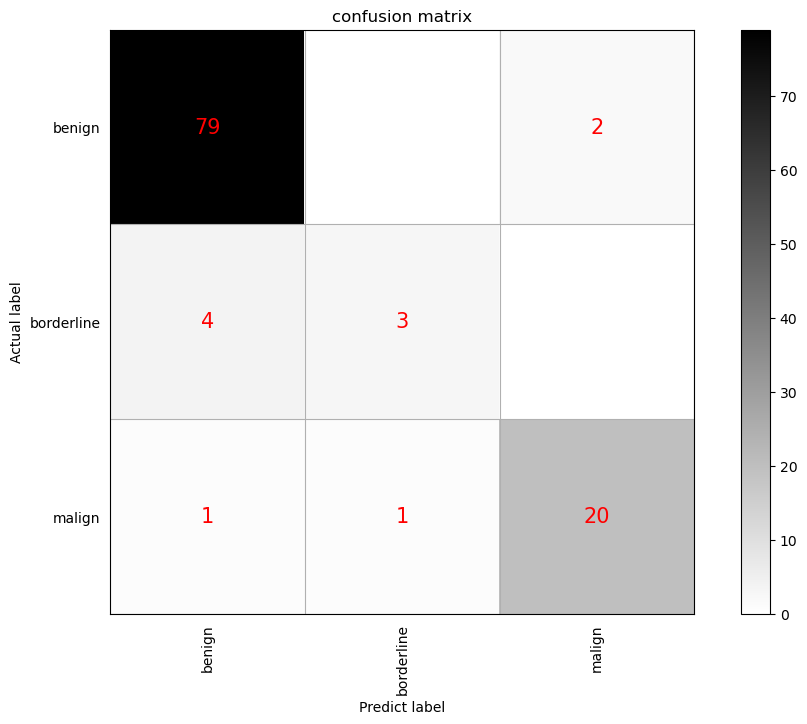

In [18]:
# classes表示不同类别的名称，比如这有6个类别
classes = ['benign','borderline','malign']
random_numbers = np.random.randint(6, size=50)  # 6个类别，随机生成50个样本
y_true = random_numbers.copy()  # 样本实际标签
random_numbers[:10] = np.random.randint(6, size=10)  # 将前10个样本的值进行随机更改
y_pred = random_numbers  # 样本预测标签

# 获取混淆矩阵
cm = confusion_matrix(metric['y'], np.argmax(metric['pred'],axis=1))
plot_confusion_matrix(cm, 'type_confusion_matrix.png', title='confusion matrix')

In [19]:
w = w.view(16*32,16,4,4)

In [20]:
a.shape,w.shape

(torch.Size([1, 256, 4, 4]), torch.Size([512, 16, 4, 4]))

In [23]:
F.conv2d(a, w)

RuntimeError: Given groups=1, weight of size [512, 16, 4, 4], expected input[1, 256, 4, 4] to have 16 channels, but got 256 channels instead

In [53]:
class Conv2DMod(nn.Module):
    def __init__(self, in_chan, out_chan, kernel, demod=True, stride=1, dilation=1, eps = 1e-8, **kwargs):
        super().__init__()
        self.filters = out_chan
        self.demod = demod
        self.kernel = kernel
        self.stride = stride
        self.dilation = dilation
        self.weight = nn.Parameter(torch.randn((out_chan, in_chan, kernel, kernel)))
        self.eps = eps
        nn.init.kaiming_normal_(self.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')

    def _get_same_padding(self, size, kernel, dilation, stride):
        return ((size - 1) * (stride - 1) + dilation * (kernel - 1)) // 2

    def forward(self, x, y):
        b, c, h, w = x.shape

        w1 = y[:, None, :, None, None]
        w2 = self.weight[None, :, :, :, :]
        print(w1.shape,w2.shape)
        weights = w2 * (w1 + 1)

        if self.demod:
            d = torch.rsqrt((weights ** 2).sum(dim=(2, 3, 4), keepdim=True) + self.eps)
            weights = weights * d

        x = x.reshape(1, -1, h, w)

        _, _, *ws = weights.shape
        weights = weights.reshape(b * self.filters, *ws)
        
        print(x.shape,weights.shape)

        padding = self._get_same_padding(h, self.kernel, self.dilation, self.stride)
        x = F.conv2d(x, weights, padding=padding, groups=b)

        x = x.reshape(-1, self.filters, h, w)
        return x

In [54]:
model = Conv2DMod(128,129,3)

In [55]:
x = torch.randn(16,128,8,8)
style = torch.randn(16,128)

In [56]:
model(x,style).shape

torch.Size([16, 1, 128, 1, 1]) torch.Size([1, 129, 128, 3, 3])
torch.Size([1, 2048, 8, 8]) torch.Size([2064, 128, 3, 3])


torch.Size([16, 129, 8, 8])